# PREPARE THE DATA

These are the steps required to prepare the data before is passed to the *"Wide and Deep"* model at `widedeep/models/wide_deep.py`

I will be using two datasets, the well known [adult dataset](https://www.kaggle.com/wenruliu/adult-income-dataset#adult.csv) and the [Airbnb dataset](http://insideairbnb.com/get-the-data.html), in particular, the last London Airbnb listings dataset collected in March, 2019. An overview of the later dataset and a "mild" pre-processing/feature-engineering can be found in the `airbnb_data_preprocessing.ipynb` notebook.

I will describe here the details of the data preparation process required to then use the wide and deep model. These have been wrapped up into two functions in the `prepare_data.py` script. One could run the script as:

    python prepare_data.py --dataset datasetname
    
where `datasetname` is either `adult` or `airbnb`. Alternatively, you can use them as simply:

    from prepare_data import prepare_data_airbnb, prepare_data_adult


in `main.py`. Note that there is a `prepare_data_...` for each dataset. This is intentional. I am sure it is possible to code a function that is dataset-agnostic. However, for the purposes of this repo, I thought that would be better to explicitly illustrate the differences in data preparation between the two datasets. These, of course, are related to the fact that the Airbnb dataset includes text and images

Let's start with the numerical and categorical features, given the fact that the treatment of numerical and categorical features is going to be the same in all datasets. 

In [2]:
import pandas as pd
import numpy as np

df_adult = pd.read_csv('data/adult/adult.csv')

# for convenience...
df_adult.columns = [c.replace("-", "_") for c in df_adult.columns]

# Let's create a categorical version of age and a feature that will be our target for logistic regression
df_adult['age_buckets'] = pd.cut(df_adult.age, bins=[16, 25, 30, 35, 40, 45, 50, 55, 60, 91], labels=np.arange(9))
df_adult['income_label'] = (df_adult["income"].apply(lambda x: ">50K" in x)).astype(int)
df_adult.drop('income', axis=1, inplace=True)
df_adult.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,age_buckets,income_label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,3,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,4,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0,0


## 1-Wide

We need to define the columns in the dataset that will be passed to the *"wide-"* and the *"deep-"* sides of the model. In our case, the *deep* side will be comprised by *deep_dense*, *deep_text* and *deep_image*. Using only *wide* and *deep_dense* is equivalent to the [original publication](https://arxiv.org/pdf/1606.07792.pdf), which I can't recommend enough. I also recommend having a look to [this tutorial](https://tensorflow-diy.readthedocs.io/en/latest/tensorflow/g3doc/tutorials/wide_and_deep/).

With that in mind let's select the columns that will be passed to through the wide-side of the model

In [3]:
df_adult.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'age_buckets', 'income_label'],
      dtype='object')

In [4]:
wide_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 
            'native_country','age_buckets']
crossed_cols = (['education', 'occupation'], ['native_country', 'occupation'])

At explained in the original paper: "For binary features, a cross-product transformation (e.g., AND(gender=female, language=en)) is 1 if and only if the constituent features (gender=female and language=en) are all 1, and 0 otherwise". Here, this is implemented by combining the features into a new feature and one-hot encoded it afterwards.

In [5]:
df_adult_wide = df_adult.copy()[wide_cols]

crossed_columns = []
for cols in crossed_cols:
    colname = '_'.join(cols)
    df_adult_wide[colname] = df_adult_wide[cols].apply(lambda x: '-'.join(x), axis=1)
    crossed_columns.append(colname)
df_adult_wide.head()

,workclass,education,marital_status,occupation,relationship,race,gender,native_country,age_buckets,education_occupation,native_country_occupation
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,0,11th-Machine-op-inspct,United-States-Machine-op-inspct
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,3,HS-grad-Farming-fishing,United-States-Farming-fishing
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,1,Assoc-acdm-Protective-serv,United-States-Protective-serv
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,4,Some-college-Machine-op-inspct,United-States-Machine-op-inspct
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States,0,Some-college-?,United-States-?


In [6]:
dummy_cols = wide_cols+crossed_columns
df_adult_wide = pd.get_dummies(df_adult_wide, columns=dummy_cols)
print(df_adult_wide.shape)

(48842, 817)


In [7]:
df_adult_wide.head()

,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital_status_Divorced,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,...,native_country_occupation_Thailand-Prof-specialty,native_country_occupation_Thailand-Protective-serv,native_country_occupation_Thailand-Sales,native_country_occupation_Thailand-Transport-moving,native_country_occupation_Trinadad&Tobago-?,native_country_occupation_Trinadad&Tobago-Adm-clerical,native_country_occupation_Trinadad&Tobago-Craft-repair,native_country_occupation_Trinadad&Tobago-Exec-managerial,native_country_occupation_Trinadad&Tobago-Machine-op-inspct,native_country_occupation_Trinadad&Tobago-Other-service,native_country_occupation_Trinadad&Tobago-Prof-specialty,native_country_occupation_Trinadad&Tobago-Protective-serv,native_country_occupation_Trinadad&Tobago-Sales,native_country_occupation_Trinadad&Tobago-Tech-support,native_country_occupation_Trinadad&Tobago-Transport-moving,native_country_occupation_United-States-?,native_country_occupation_United-States-Adm-clerical,native_country_occupation_United-States-Armed-Forces,native_country_occupation_United-States-Craft-repair,native_country_occupation_United-States-Exec-managerial,native_country_occupation_United-States-Farming-fishing,native_country_occupation_United-States-Handlers-cleaners,native_country_occupation_United-States-Machine-op-inspct,native_country_occupation_United-States-Other-service,native_country_occupation_United-States-Priv-house-serv,native_country_occupation_United-States-Prof-specialty,native_country_occupation_United-States-Protective-serv,native_country_occupation_United-States-Sales,native_country_occupation_United-States-Tech-support,native_country_occupation_United-States-Transport-moving,native_country_occupation_Vietnam-?,native_country_occupation_Vietnam-Adm-clerical,native_country_occupation_Vietnam-Craft-repair,native_country_occupation_Vietnam-Exec-managerial,native_country_occupation_Vietnam-Farming-fishing,native_country_occupation_Vietnam-Handlers-cleaners,native_country_occupation_Vietnam-Machine-op-inspct,native_country_occupation_Vietnam-Other-service,native_country_occupation_Vietnam-Prof-specialty,native_country_occupation_Vietnam-Sales,native_country_occupation_Vietnam-Tech-support,native_country_occupation_Vietnam-Transport-moving,native_country_occupation_Yugoslavia-Adm-clerical,native_country_occupation_Yugoslavia-Craft-repair,native_country_occupation_Yugoslavia-Exec-managerial,native_country_occupation_Yugoslavia-Farming-fishing,native_country_occupation_Yugoslavia-Machine-op-inspct,native_country_occupation_Yugoslavia-Other-service,native_country_occupation_Yugoslavia-Priv-house-serv,native_country_occupation_Yugoslavia-Transport-moving
0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,

When we one-hot encode the crossed_columns, their value is 1 *if and only* if the two constituent features are 1. In other words, the level `Bachelors-Adm-clerical` of the `education_occupation` feature will be 1 *if and only if* for that particular observation `education=Bachelors` AND `occupation=Adm-clerical`.

## Deep Dense

As before, let's define the columns that will be passed through the deep-dense side. This is, represented as embeddings and then passed through a series of dense layers.

In [8]:
df_adult.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,age_buckets,income_label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,3,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,4,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0,0


In [9]:
embeddings_cols = [ ('workclass',10), ('education',10), ('occupation',10), ('relationship',8), 
                   ('native_country',10)]
continuous_cols = ["age", "hours_per_week", "capital_gain", "capital_loss"]

You will see that `embeddings_cols` is a list of tuples with two elements. These are the column name and the "dimension of the corresponding embeddings" (i.e. the number of embeddings per feature), so that when passed through the deep-dense side *education* will be represented by 10 embeddings, *relatioship* by 8, etc.

If you want to use the same number of embeddings for *all* the embedding columns you can simply include the column names and define the number of embeddings when calling to the `prepare_data_...` functions I mention before. This functions have a parameter called `def_dim` (default dimension) that will be applied to all embedding columns if no embedding dimension is passed. Let's go to the code/

In [10]:
def_dim = 8
if type(embeddings_cols[0]) is tuple:
    emb_dim = dict(embeddings_cols)
    embeddings_coln = [emb[0] for emb in embeddings_cols]
else:
    emb_dim = {e:def_dim for e in embeddings_cols}
    embeddings_coln = embeddings_cols
deep_cols = embeddings_coln+continuous_cols
deep_cols

['workclass',
 'education',
 'occupation',
 'relationship',
 'native_country',
 'age',
 'hours_per_week',
 'capital_gain',
 'capital_loss']

In [11]:
df_adult_deep = df_adult.copy()[deep_cols]

# Extract the categorical column names that will be label_encoded
categorical_columns = list(df_adult_deep.select_dtypes(include=['object']).columns)
categorical_columns

['workclass', 'education', 'occupation', 'relationship', 'native_country']

Now we need to "label encode" these categorical features. to that aim I normally prefer to use my own function instead of sklearn's `LabelEncoder`. This is because I find accessing to the encoding dictionary a bit convoluted when using `LabelEncoder`.  

In [12]:
def label_encode(df_inp, cols=None, val_to_idx=None):
    """
    Helper function to label-encode some features of a given dataset.

    Parameters:
    -----------
    df_inp: pd.Dataframe
        input dataframe
    cols: List 
        optional - columns to be label-encoded
    val_to_idx: Dict
        optional - dictionary with the encodings
    
    Returns:
    --------
    val_to_idx: Dict
        Dictionary with the encoding information
    df: pd.Dataframe 
        df with Label-encoded features.
    """

    df = df_inp.copy()

    if cols == None:
        cols = list(df.select_dtypes(include=['object']).columns)

    if not val_to_idx:

        val_types = dict()
        for c in cols:
            val_types[c] = df[c].unique()

        val_to_idx = dict()
        for k, v in val_types.items():
            val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x])

    return df, val_to_idx

In [13]:
df_adult_deep, encoding_dict = label_encode(df_adult_deep, cols=categorical_columns)
embeddings_encoding_dict = {k:encoding_dict[k] for k in encoding_dict if k in deep_cols}
embeddings_input = []
for k,v in embeddings_encoding_dict.items():
    embeddings_input.append((k, len(v), emb_dim[k]))
deep_column_idx = {k:v for v,k in enumerate(df_adult_deep.columns)}

In [14]:
embeddings_encoding_dict

{'workclass': {'Private': 0,
  'Local-gov': 1,
  '?': 2,
  'Self-emp-not-inc': 3,
  'Federal-gov': 4,
  'State-gov': 5,
  'Self-emp-inc': 6,
  'Without-pay': 7,
  'Never-worked': 8},
 'education': {'11th': 0,
  'HS-grad': 1,
  'Assoc-acdm': 2,
  'Some-college': 3,
  '10th': 4,
  'Prof-school': 5,
  '7th-8th': 6,
  'Bachelors': 7,
  'Masters': 8,
  'Doctorate': 9,
  '5th-6th': 10,
  'Assoc-voc': 11,
  '9th': 12,
  '12th': 13,
  '1st-4th': 14,
  'Preschool': 15},
 'occupation': {'Machine-op-inspct': 0,
  'Farming-fishing': 1,
  'Protective-serv': 2,
  '?': 3,
  'Other-service': 4,
  'Prof-specialty': 5,
  'Craft-repair': 6,
  'Adm-clerical': 7,
  'Exec-managerial': 8,
  'Tech-support': 9,
  'Sales': 10,
  'Priv-house-serv': 11,
  'Transport-moving': 12,
  'Handlers-cleaners': 13,
  'Armed-Forces': 14},
 'relationship': {'Own-child': 0,
  'Husband': 1,
  'Not-in-family': 2,
  'Unmarried': 3,
  'Wife': 4,
  'Other-relative': 5},
 'native_country': {'United-States': 0,
  '?': 1,
  'Peru': 2

In [15]:
embeddings_input

[('workclass', 9, 10),
 ('education', 16, 10),
 ('occupation', 15, 10),
 ('relationship', 6, 8),
 ('native_country', 42, 10)]

This reads as: "workclass has 9 different values and will be encoded as 10-dim embeddings"

In [16]:
df_adult_deep.head()

,workclass,education,occupation,relationship,native_country,age,hours_per_week,capital_gain,capital_loss
0,0,0,0,0,0,25,40,0,0
1,0,1,1,1,0,38,50,0,0
2,1,2,2,1,0,28,40,0,0
3,0,3,0,1,0,44,40,7688,0
4,2,3,3,0,0,18,30,0,0


and now let's scale the continuous columns

In [17]:
from sklearn.preprocessing import StandardScaler
standardize_cols = continuous_cols
scaler = StandardScaler()
for cc in standardize_cols:
    df_adult_deep[cc]  = scaler.fit_transform(df_adult_deep[cc].values.reshape(-1,1).astype(float))
df_adult_deep.head()

,workclass,education,occupation,relationship,native_country,age,hours_per_week,capital_gain,capital_loss
0,0,0,0,0,0,-0.995129,-0.034087,-0.144804,-0.217127
1,0,1,1,1,0,-0.046942,0.772930,-0.144804,-0.217127
2,1,2,2,1,0,-0.776316,-0.034087,-0.144804,-0.217127
3,0,3,0,1,0,0.390683,-0.034087,0.886874,-0.217127
4,2,3,3,0,0,-1.505691,-0.841104,-0.144804,-0.217127


If we were not going to combine numerical and categorical features with text and images, this would be it. One would save this information in an adequate format (I "pickled" a dictionary) and feed this to the model, as I will illustrate in the demo3. 

Let's see now how one prepares the text and images sets. For the following sections we will be using the [Airbnb dataset](http://insideairbnb.com/get-the-data.html) I mentioned before. This dataset has been slightly preprocessed. All the details can be found in this notebook `airbnb_data_preprocessing.ipynb`. The following code assumes that you have run the notebook's companion script `airbnb_data_preprocessing.py` and that a file names `listings_processed.csv` is saved at `../data/airbnb`

## Deep Text

When using the Airbnb dataset, the text that is going to be combined with numerical and categorical features will be the descriptions. There are more text columns in the original dataset, but one woud assume that the property descriptions will be the most informative.

In [17]:
# For illustration purposes we will focus here on descriptions of 20 words or more.
from random import sample
df_airbnb = pd.read_csv('data/airbnb/listings_processed.csv')
df_airbnb = df_airbnb[df_airbnb.description.apply(lambda x: len(x.split(' '))>=20)]
texts = df_airbnb.description.tolist()
sample(texts, 2)

['Relax, re-charge your batteries and feel like home in a modern, clean, tastefully furnished and safe apartment situated in a well maintained 19th century Victorian building, and its charming south-facing private garden.',
 'Excellent access to central London. Spacious bright modern apartment Spacious 3 bed room apartment situated conveniently close to Wimbledon town centre and Wimbledon tennis.10 mins walk to wimbledon station, 5 minute walk to Haydons road station and bus stops on road 100m away.']

Now, let me comment for a second before moving to the next cells. There are always a number of ways to deal with/preprocess text. Of course, chosing one or the other will influence the final results of your project. For example, we could chose to lowercase all the tokens in our vocabulary, which is a common practice. However, this might miss some important information. In Airbnb descriptions is likely that the owner writes in capitals those words that he/she believes require more attention. Perhaps, ultimately, this leads to more bookings and a higher `yield` value, which is what we aim to predict. I believe that these details will not be that important here, where we are performing a regression excercise, but if you wanted to build a language model ("The Airbnb Description LM") such considerations are fundamental. 

With these considerations in mind, I decided to use the `fastai` [Tokenizer](https://docs.fast.ai/text.transform.html#Tokenizer), which comes with a series of very useful rules for tokenization. It uses `spacy`'s tokenizer, which is good and really, really fast. The `fastai` course is one of this pieces of gold out there in the internet. If you have the opportunity and the time, I highly recommend you have a look. 

In [18]:
from typing import List
from gensim.utils import tokenize
from fastai.text import Tokenizer

def simple_preprocess(doc, lower=False, min_len=2, max_len=15):
    """
    My own adaptation of gensim's simple_preprocess where we can chose to not lowercase tokens
    """
    tokens = [
        token for token in tokenize(doc, lower=lower, errors='ignore')
        if min_len <= len(token) <= max_len and not token.startswith('_')
    ]
    return tokens

def get_texts_gensim(texts):
    processed_textx = [' '.join(simple_preprocess(t)) for t in texts]
    tok = Tokenizer().process_all(processed_textx)
    return tok

In [19]:
tokens = get_texts_gensim(texts)

let's have a look to the tokens for the first description

In [20]:
texts[0][:100]

'My bright double bedroom with a large window has a relaxed feeling! It comfortably fits one or two a'

In [21]:
print(tokens[0][:13])

['xxmaj', 'my', 'bright', 'double', 'bedroom', 'with', 'large', 'window', 'has', 'relaxed', 'feeling', 'xxmaj', 'it']


For example, the token "xxmaj" indicates that the next word begins with a capital in the original text. 

Let's now build our vocabulary for which we will also use `fastai`'s `Vocab` class

In [22]:
from fastai.text import Vocab

vocab = Vocab.create(tokens, max_vocab=20000, min_freq=2)
sequences = [vocab.numericalize(t) for t in tokens]

In [23]:
print(sequences[0])

[5, 55, 111, 31, 26, 14, 51, 555, 35, 877, 1162, 5, 29, 575, 1675, 58, 41, 71, 9, 12, 804, 54, 75, 71, 2265, 20, 5, 806, 5, 56, 5, 134, 72, 65, 13, 10, 43, 9, 121, 52, 11, 121, 112, 1146, 417, 9, 209, 5, 2497, 9, 470, 15, 40, 3535, 24, 144, 5, 1248, 5, 1054, 589, 55, 88, 31, 26, 13, 5, 806, 5, 56, 43, 229, 18, 492, 13, 138, 27, 5, 16, 33, 365, 10, 27, 14, 253, 9, 29, 12, 87, 251, 14, 422, 1296, 23, 5, 71, 135, 50, 506, 382, 86, 42, 10, 19, 35, 598, 174, 28, 62, 37, 433, 767, 18, 1012, 18, 173, 14, 146, 470, 33, 1152, 2241, 128, 316, 42, 893, 0, 25, 219, 63, 891, 9, 33, 44, 1483, 283, 11, 16, 272, 16, 2168, 10, 455, 3413, 934, 277, 33, 44, 10246, 11, 36, 1471, 295, 1229, 55, 67, 14, 1492, 9, 991, 5, 239, 5, 4702, 5, 13731, 5, 173, 33, 37, 52, 11, 10, 422, 1296, 23, 9, 39, 5, 34, 12, 10, 21, 12, 101, 131, 355]


Let's find the distribution of sequences' lengths and pad accordingly

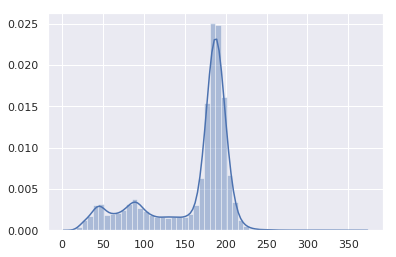

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

lengths = [len(s) for s in sequences]
sns.distplot(lengths)

We can see that actually, a lot of sequences/descriptions are quite lengthy. I am going to pad sequences below 190 tokens. 

In [25]:
def pad_sequences(seq, maxlen=190, pad_first=True, pad_idx=1):
    if len(seq) >= maxlen:
        res = np.array(seq[-maxlen:]).astype('int32')
        return res
    else:
        res = np.zeros(maxlen, dtype='int32') + pad_idx
        if pad_first: res[-len(seq):] = seq
        else:         res[:len(seq):] = seq
        return res

In [26]:
padded_seq = np.array([pad_sequences(s) for s in sequences])

A priori, we could consider this done. However, there is one last step in preparing the text data before being passed to Wide and Deep. Normally it is always a good idea to use pretrained inputs, in this case, pretrained embeddings. With that in mind I have included both the [Glove](https://nlp.stanford.edu/projects/glove/) or [FastText](https://fasttext.cc/docs/en/english-vectors.html) vectors. I will not run the correponding code here (loading the glove vectors is fast, but fasttext text a while). The function I use to build the embedding matrix is the following.  

In [27]:
def build_embeddings_matrix(vocab, word_vectors_file):

    if 'fasttext' in word_vectors_file:
        word_vectors = 'fasttext'
    elif 'glove' in word_vectors_file:
        word_vectors = 'glove'

    print('Indexing word vectors.')
    embeddings_index = {}
    f = open(word_vectors_file)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded {} word vectors'.format(len(embeddings_index)))

    print('Preparing embeddings matrix.')
    mean_word_vector = np.mean(list(embeddings_index.values()), axis=0)
    embedding_dim = len(list(embeddings_index.values())[0])
    num_words = len(vocab.itos)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    found_words=0
    for i,word in enumerate(vocab.itos):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            found_words+=1
        else:
            embedding_matrix[i] = mean_word_vector
    print('{} words in our vocabulary had {} vectors and appear more than the min frequency'.format(found_words, word_vectors))

    return embedding_matrix


"Deep-Text" done, as with Wide and Deep-Dense the resulting dataset will be saved in a dictionary so that is later used by the model (see the `prepare_data.py` file). Let's move to the last type of data, images

## Deep-Image

The Airbnb dataset includes urls pointing to the images of the hosts and their properties. Images of the hosts are available in large, medium and small sizes while property pictures are only available in large and extra large sizes. I wrote a function to download the images which can be found in the script `download_images.py`. After running this script you will download 38266 host images and 55931 images of their properties. 

In the following I will assume that this script has run (it will take quite a while to download the images). Let's have a look to some imgs

In [21]:
import cv2
from os import listdir

host_img_path = "data/airbnb/host_picture/"
host_imgnames = listdir(host_img_path)
host_imgnames = sample(host_imgnames, 10)
prop_img_path = "data/airbnb/property_picture/"
prop_imgnames = listdir(prop_img_path)
prop_imgnames = sample(prop_imgnames, 10)
print(host_imgnames)
print(prop_imgnames)

['12722004.jpg', '11523621.jpg', '237370175.jpg', '36076235.jpg', '34638735.jpg', '5488449.jpg', '96276841.jpg', '6622752.jpg', '2267668.jpg', '37024990.jpg']
['25175433.jpg', '8497087.jpg', '22500232.jpg', '11570006.jpg', '23218870.jpg', '17293977.jpg', '12108448.jpg', '8458558.jpg', '24295352.jpg', '2802932.jpg']


In [22]:
# read images and move them to RGB (this later step is implemented just here for plotting purposes)
host_imgs = [cv2.imread(str(host_img_path+img)) for img in host_imgnames]
host_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in host_imgs]

prop_imgs = [cv2.imread(str(prop_img_path+img)) for img in prop_imgnames]
prop_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in prop_imgs]

In [23]:
# Stole this function from the fastai course...again
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(im, figsize=(5,5), ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_axis_off()
    return ax

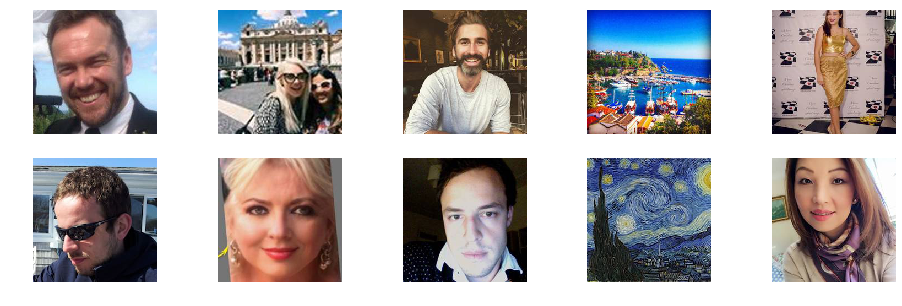

In [24]:
fig,axes = plt.subplots(2, 5, figsize=(16,5))
for i,im in enumerate(host_imgs):
    show_img(im, ax=axes.flat[i])

In [25]:
print([im.shape for im in host_imgs])

[(225, 225, 3), (225, 225, 3), (225, 225, 3), (225, 225, 3), (225, 225, 3), (225, 225, 3), (225, 225, 3), (225, 225, 3), (225, 225, 3), (225, 225, 3)]


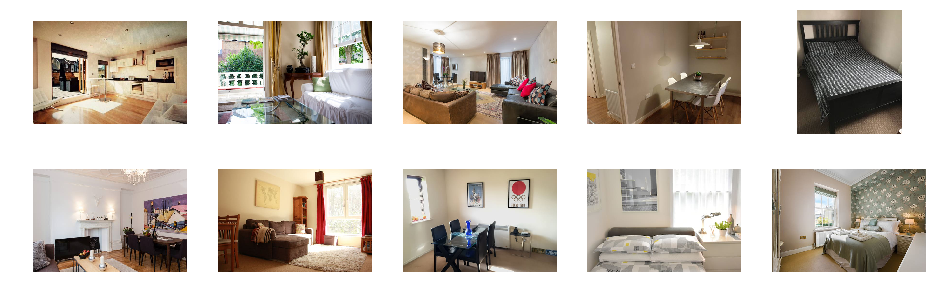

In [26]:
fig,axes = plt.subplots(2, 5, figsize=(16,5))
for i,im in enumerate(prop_imgs):
    show_img(im, ax=axes.flat[i])

In [27]:
print([im.shape for im in prop_imgs])

[(426, 639, 3), (426, 639, 3), (426, 639, 3), (426, 639, 3), (426, 360, 3), (426, 639, 3), (426, 639, 3), (426, 639, 3), (426, 639, 3), (426, 639, 3)]


For this regression excercise we will be using a pretrained network (as always, if you can use pretrained "stuff", do it). In particular, I will be using [ResNet](https://arxiv.org/abs/1512.03385). This architecture takes 224x224 images as input. Therefore, the images will be simply preprocessed to ensure they have this size. Note that this could be done with `torchvision.transforms` as we load the images, using some padding technique if the image is of smaller size than 224x224. However, here I prefer to resize them before and use a tranformation that will preserve the aspect of the image. As with many things in life, using the following code or `torchvision.transforms` is a matter of choice, whichever you prefer. 

The following function is literally taken from the great [Deep Learning for Computer Vision](https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/) book by [Adrian](https://www.linkedin.com/in/adrian-rosebrock-59b8732a/). As with the fastai course, I highly recommend checking all the materials that Adrian constantly writes online.  

In [28]:
import imutils

class AspectAwarePreprocessor:

    def __init__(self, width:int, height:int, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image:np.ndarray) -> np.ndarray:
        (h, w) = image.shape[:2]

        dW = 0
        dH = 0

        if w < h:
            image = imutils.resize(image, width=self.width,
                inter=self.inter)
            dH = int((image.shape[0] - self.height) / 2.0)

        else:
            image = imutils.resize(image, height=self.height,
                inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)

        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]

        return cv2.resize(image, (self.width, self.height),
            interpolation=self.inter)


In [29]:
spp = AspectAwarePreprocessor(224,224)
host_resized_imgs = [spp.preprocess(im) for im in host_imgs]

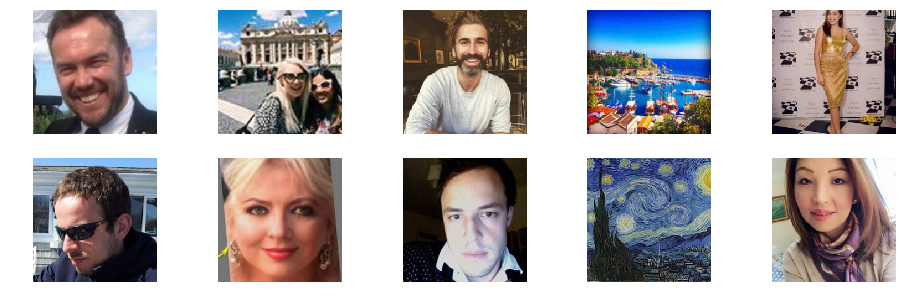

In [30]:
fig,axes = plt.subplots(2, 5, figsize=(16,5))
for i,im in enumerate(host_resized_imgs):
    show_img(im, ax=axes.flat[i])

In [31]:
print([im.shape for im in host_resized_imgs])

[(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]


In [32]:
prop_resized_imgs = [spp.preprocess(im) for im in prop_imgs]

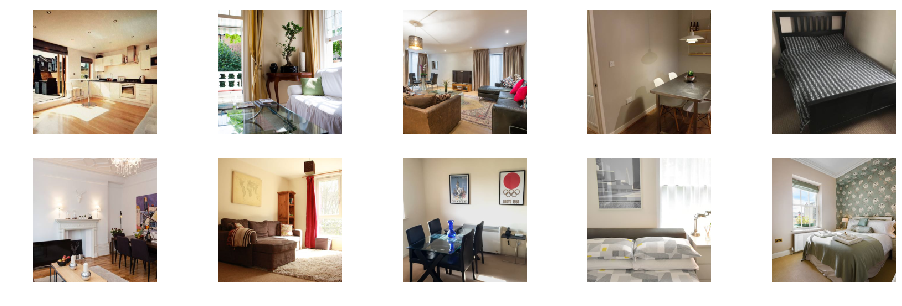

In [33]:
fig,axes = plt.subplots(2, 5, figsize=(16,5))
for i,im in enumerate(prop_resized_imgs):
    show_img(im, ax=axes.flat[i])

In [34]:
print([im.shape for im in prop_resized_imgs])

[(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]


As you can see, in this case we lose some information in the images. My goal here is mostly illustrate how one could combine categorical and numerical features with images and text. If someone wants to be more thorough on processing the images I suggest the following: resizing along the major axis to 224. The resizing along the minor axis keeping the aspect. Once this is done, add reflection padding so that the final image is 224x224. 

And that's it when it comes to preparing the images. As with Wide, Deep-Dense and Deep-text, the numpy arrays will be saved in a dictionary that will be later used by the model. 